In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from os.path import expanduser
from tqdm import tqdm
from aesthetics import plotting
import csv
import operator

import scipy.stats as ss
from scipy.stats import sem, pearsonr, zscore

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
data_path = expanduser('~/data/katie/')
control_name = '041117_Controls_Revised.csv'
# experimental_name = '041117_Revised_Norm_Exp_Sans_D3.csv'
experimental_name = '2017-05-02_Stringent_outlier_removal_with_avg_plus_sd.csv'

In [3]:
controlfile = open(data_path + control_name, 'r')
control_reader = csv.reader(controlfile)

In [4]:
control_list = collections.defaultdict(list)
labels = []
for idl,line in enumerate(control_reader):
    if idl == 0:
        for l in line:
            labels.append(l)
    else:
        if line[0] != '':
#             print(line[0])
            for idi,l in enumerate(line):
                if l == '':
                    control_list[labels[idi]].append(np.nan)
                elif idi > 0:
                    control_list[labels[idi]].append(float(l))
                elif idi == 0:
                    control_list[labels[idi]].append(l)

In [5]:
for m in control_list['Mouse']:
    # mouse id x day
    this_split = m.split('.')
    control_list['mouse_id'] = this_split[0]

In [6]:
variables = [k for k in control_list.keys() if k not in ['mouse_id', 'Mouse', 'DPI', 'Infected (1/0)',
                                                        'Parasitemia', 'Parasite Density', 'Accuri', 'Cells',
                                                        'palmitoyl-arachidonoyl-glycerol (16:0/20:4) [2]*',
                                                        'palmitoyl-linoleoyl-glycerol (16:0/18:2) [1]*',
                                                        'Direct Bilirubin', 
                                                         'lactosyl-N-palmitoyl-sphingosine (d18:1/16:0)',
                                                         'cerotoylcarnitine (C26)*', 'GGT']]

In [7]:
variables

['3-(4-hydroxyphenyl)lactate',
 'N-acetylleucine',
 'IL-10',
 '2,8-quinolinediol sulfate',
 '1-stearoyl-2-oleoyl-GPE (18:0/18:1)',
 'putrescine',
 'cinnamoylglycine',
 'sphingomyelin (d18:2/18:1)*',
 '3-hydroxyisobutyrate',
 '1-stearoyl-2-arachidonoyl-GPS (18:0/20:4)',
 '1-(1-enyl-palmitoyl)-GPE (P-16:0)*',
 '1-palmitoyl-GPG (16:0)*',
 'orotate',
 '1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*',
 'sphingomyelin (d18:2/16:0, d18:1/16:1)*',
 'IL-5',
 '2-methylbutyrylcarnitine (C5)',
 '1-palmitoyl-2-oleoyl-GPE (16:0/18:1)',
 'palmitoleate (16:1n7)',
 'indoleacrylate',
 'EOTAXIN',
 '2-oxindole-3-acetate',
 'myristate (14:0)',
 'phosphate',
 '1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*',
 'tauro-alpha-muricholate',
 'N6-carbamoylthreonyladenosine',
 'sphingomyelin (d18:1/14:0, d16:1/16:0)*',
 '1-oleoyl-GPE (18:1)',
 '1-oleoyl-GPC (18:1)',
 'fructose',
 'diacylglycerol (16:1/18:2 [2], 16:0/18:3 [1])*',
 'gamma-glutamylleucine',
 '7-methylguanine',
 '2-aminoheptanoate',
 'S-adenosy

In [8]:
time = control_list['DPI']

# Load experimental data

In [9]:
experimental_file = open(data_path + experimental_name, 'r')
experimental_reader = csv.reader(experimental_file)

experimental_list = collections.defaultdict(list)
labels = []
for idl,line in enumerate(experimental_reader):
    if idl == 0:
        for l in line:
            labels.append(l)
    else:
        if line[0] != '':
#             print(line[0])
            for idi,l in enumerate(line):
                if l == '':
                    experimental_list[labels[idi]].append(np.nan)
                elif idi > 0:
                    experimental_list[labels[idi]].append(float(l))
                elif idi == 0:
                    experimental_list[labels[idi]].append(l)

In [10]:
for m in experimental_list['Mouse']:
    # mouse id x day
    this_split = m.split('.')
    experimental_list['mouse_id'] = this_split[0]

In [11]:
time_experimental = experimental_list['DPI']

#### Average data points that fall on the same day

In [12]:
average_experimental_time = sorted(np.unique(time_experimental))

In [13]:
averaged_experimental_data = collections.defaultdict(list)
for v in variables:
    averaged_vals = []
    these_vals = experimental_list[v]
    for t in average_experimental_time:
        averaged_vals.append(np.nanmean([val for i,val in enumerate(these_vals) if time_experimental[i] == t]))
    averaged_experimental_data[v] = np.array(averaged_vals)

In [14]:
len(averaged_experimental_data.keys())

635

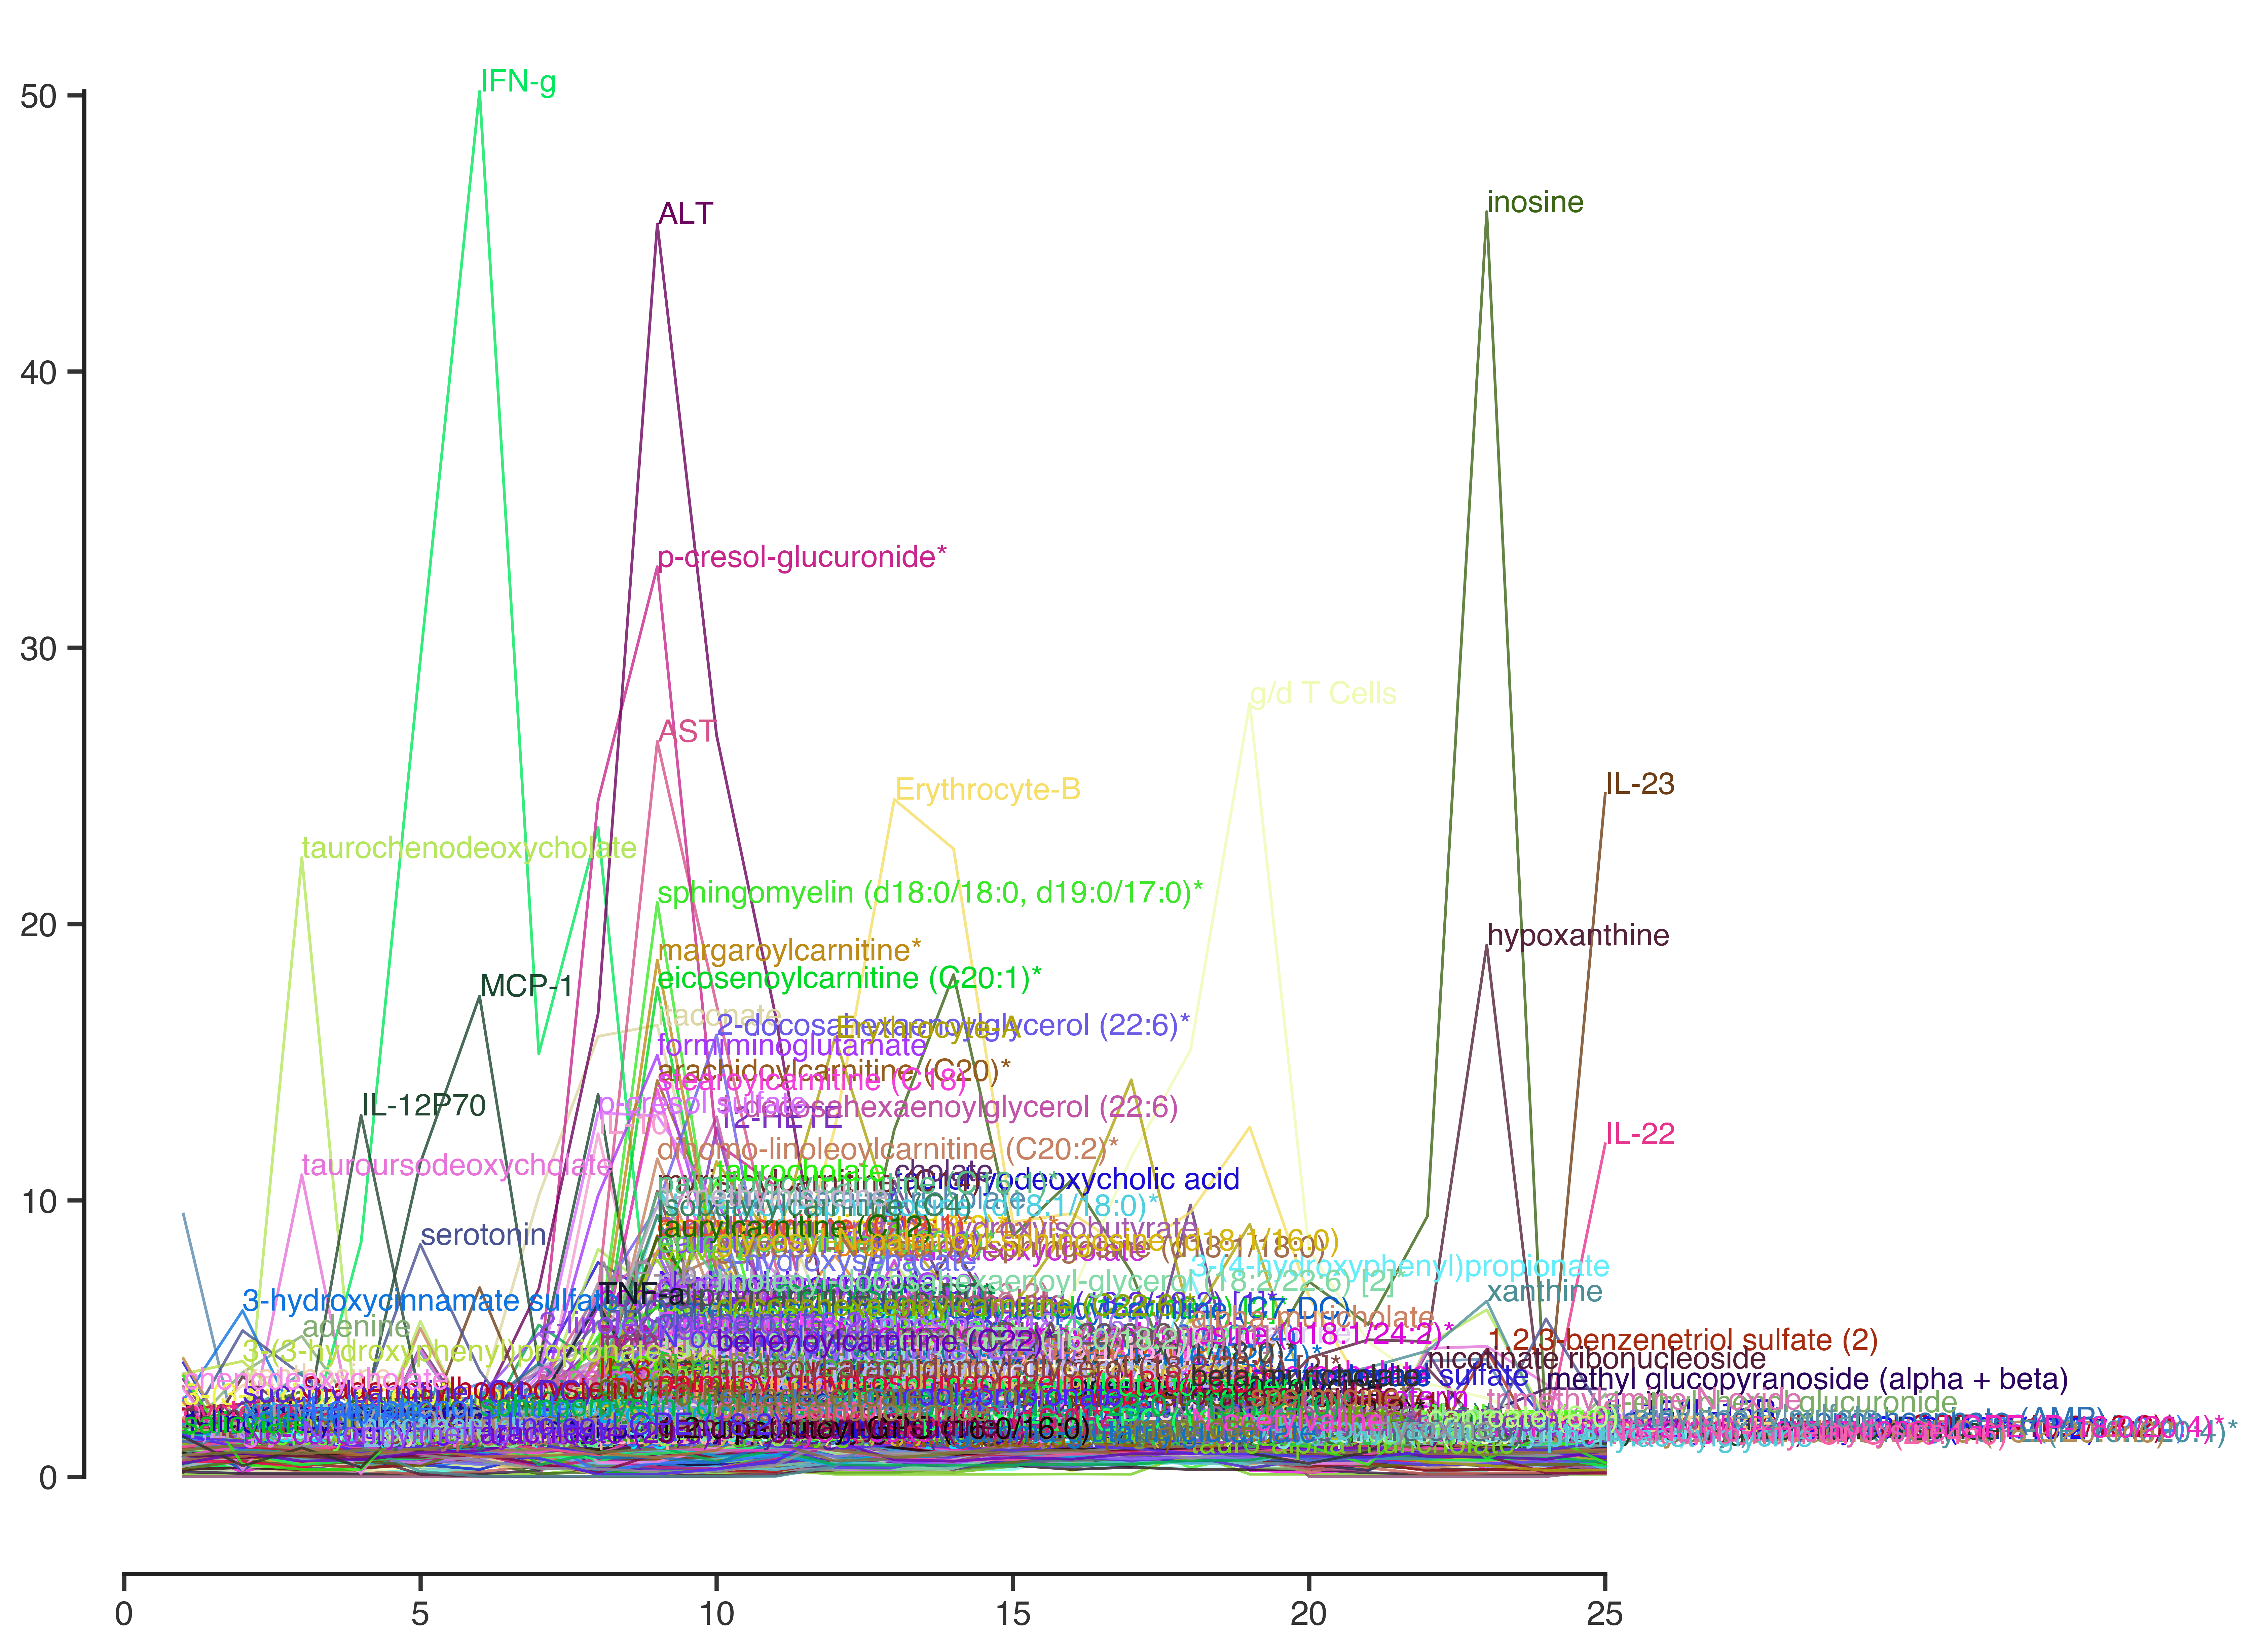

In [15]:
fig = plt.gcf()
fig.set_size_inches((10,10))

for var in averaged_experimental_data.keys():
    random_color = np.random.rand(3)
    plt.plot(average_experimental_time, averaged_experimental_data[var], linewidth=1, alpha=0.8,
             color=random_color)
    plt.text(average_experimental_time[np.argmax(averaged_experimental_data[var])],
             np.max(averaged_experimental_data[var]),
             '%s' %var, color=random_color, fontsize=11)
    
plotting.adjust_spines(plt.gca())

## With normal distribution

In [16]:
# this will be likelihood of all data points
normal_sum_neg_ll = collections.defaultdict(list)
# this will be likelihood of the averaged (within day) data points
normal_sum_neg_ll_avg = collections.defaultdict(list)
for v in tqdm(variables):
    these_control_vals = np.array(control_list[v])
    these_control_vals = these_control_vals[~np.isnan(these_control_vals)]
    this_dist = ss.norm.fit(these_control_vals)
            
    these_exp_vals = np.array(experimental_list[v])
    these_exp_vals = these_exp_vals[~np.isnan(these_exp_vals)]

    neg_logpdf = -ss.norm.logpdf(these_exp_vals, *this_dist)
    neg_logpdf_avg = -ss.norm.logpdf(averaged_experimental_data[v] - np.nanmin(averaged_experimental_data[v]),
                                      *this_dist)
    normal_sum_neg_ll[v] = np.sum(neg_logpdf)
    normal_sum_neg_ll_avg[v] = np.sum(neg_logpdf_avg)
    
normal_least_likely_data = sorted(normal_sum_neg_ll.items(), key=operator.itemgetter(1), reverse=True)
normal_least_likely_data_avg = sorted(normal_sum_neg_ll_avg.items(), key=operator.itemgetter(1), reverse=True)

100%|██████████| 635/635 [00:00<00:00, 3098.71it/s]


In [17]:
for i in range(10):
    print(normal_least_likely_data[i])

('itaconate', 672419.07725354913)
('IFN-g', 158959.13383873928)
('Erythrocyte-B', 106697.60295728623)
('ALT', 79947.575268224624)
('MCP-1', 32715.512822505116)
('orotate', 30273.317495967251)
('g/d T Cells', 26574.726404561992)
('AST', 22710.796256999474)
('IL-12P70', 22131.395588285319)
('methylsuccinate', 21864.359784626744)


In [18]:
for i in range(10):
    print(normal_least_likely_data_avg[i])

('itaconate', 134007.4048087812)
('IFN-g', 28540.911370638769)
('Erythrocyte-B', 21033.234237685308)
('ALT', 11415.061945840651)
('MCP-1', 5595.6163728539359)
('g/d T Cells', 5565.539749934338)
('orotate', 4103.8961328389842)
('AST', 3943.2708205307972)
('IL-12P70', 3934.157680966568)
('methylsuccinate', 3042.7990118997495)


In [19]:
name, csv_ext = experimental_name.split('.')
with open('2017-05-02_Ranked_least_likely_normal_distribution_%s.csv' %name, 'w') as csvfile:
    this_writer = csv.writer(csvfile, delimiter=',')
    for var_name, nllv in normal_least_likely_data:
        this_writer.writerow([var_name, nllv])
        
with open('2017-05-02_Ranked_least_likely_normal_distribution_avg_%s.csv' %name, 'w') as csvfile:
    this_writer = csv.writer(csvfile, delimiter=',')
    for var_name, nllv in normal_least_likely_data_avg:
        this_writer.writerow([var_name, nllv])